In [23]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [24]:
batch_size = 32
img_height = 180
img_width = 180

In [38]:
data_dir = "Pistachio_Image_Dataset_Train"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1933 files belonging to 2 classes.
Using 1547 files for training.


In [26]:
data_dir = "Pistachio_Image_Dataset_Train"
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1933 files belonging to 2 classes.
Using 386 files for validation.


In [27]:
class_names = train_ds.class_names
print(class_names)

['Kirmizi_Pistachio', 'Siirt_Pistachio']


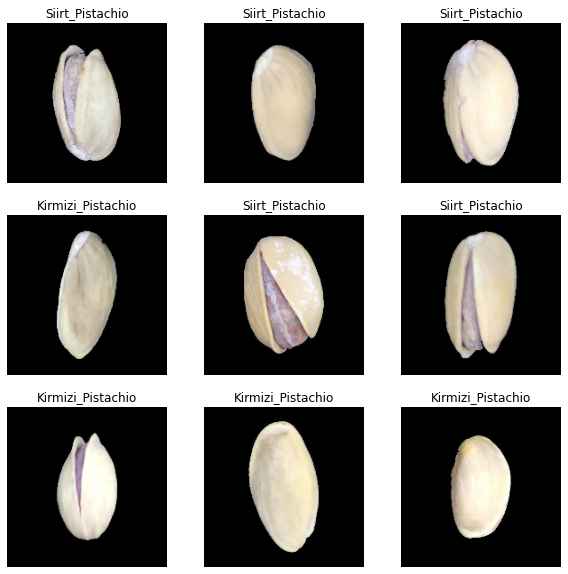

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

(32, 180, 180, 3)
(32,)


In [30]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [37]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [42]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
49/49 [==============================] - 21s 411ms/step - loss: 0.4410 - accuracy: 0.7809 - val_loss: 0.4281 - val_accuracy: 0.8212
Epoch 2/10
49/49 [==============================] - 19s 380ms/step - loss: 0.3322 - accuracy: 0.8565 - val_loss: 0.4162 - val_accuracy: 0.8187
Epoch 3/10
49/49 [==============================] - 18s 377ms/step - loss: 0.2987 - accuracy: 0.8662 - val_loss: 0.3996 - val_accuracy: 0.8368
Epoch 4/10
49/49 [==============================] - 18s 378ms/step - loss: 0.2615 - accuracy: 0.8849 - val_loss: 0.4057 - val_accuracy: 0.8290
Epoch 5/10
49/49 [==============================] - 20s 407ms/step - loss: 0.2247 - accuracy: 0.9089 - val_loss: 0.3927 - val_accuracy: 0.8497
Epoch 6/10
49/49 [==============================] - 19s 380ms/step - loss: 0.1788 - accuracy: 0.9282 - val_loss: 0.4316 - val_accuracy: 0.8446
Epoch 7/10
49/49 [==============================] - 19s 380ms/step - loss: 0.1429 - accuracy: 0.9489 - val_loss: 0.4462 - val_accuracy: 0.8653

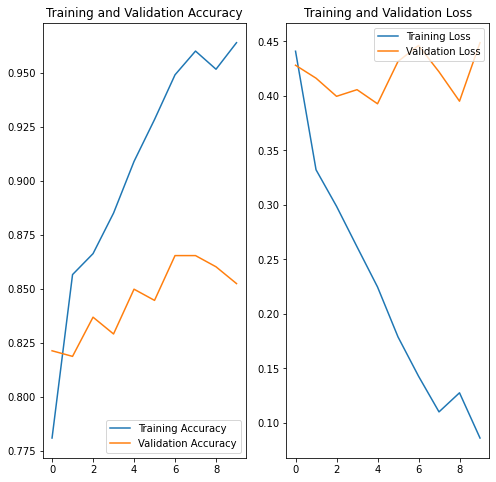

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

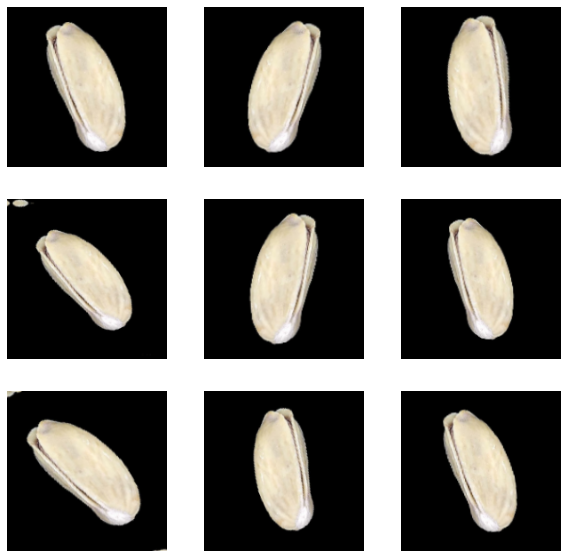

In [45]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [46]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
49/49 [==============================] - 22s 440ms/step - loss: 0.6115 - accuracy: 0.6923 - val_loss: 0.4328 - val_accuracy: 0.8342
Epoch 2/15
49/49 [==============================] - 21s 431ms/step - loss: 0.4385 - accuracy: 0.7996 - val_loss: 0.4453 - val_accuracy: 0.8005
Epoch 3/15
49/49 [==============================] - 21s 429ms/step - loss: 0.4135 - accuracy: 0.8074 - val_loss: 0.5225 - val_accuracy: 0.7798
Epoch 4/15
49/49 [==============================] - 21s 430ms/step - loss: 0.3971 - accuracy: 0.8222 - val_loss: 0.4120 - val_accuracy: 0.8212
Epoch 5/15
49/49 [==============================] - 21s 429ms/step - loss: 0.4020 - accuracy: 0.8158 - val_loss: 0.4846 - val_accuracy: 0.7746
Epoch 6/15
49/49 [==============================] - 21s 430ms/step - loss: 0.3988 - accuracy: 0.8132 - val_loss: 0.5005 - val_accuracy: 0.7824
Epoch 7/15
49/49 [==============================] - 21s 430ms/step - loss: 0.3779 - accuracy: 0.8332 - val_loss: 0.5424 - val_accuracy: 0.7824

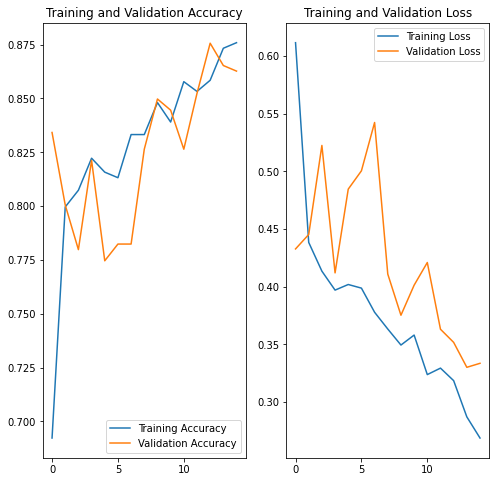

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
import shap


In [66]:
img = tf.io.read_file(f"/home/alexandre/Mestrado/Aprendizagem de Maquina/ama2022-pistachio/Pistachio_Image_Dataset_Train/Kirmizi_Pistachio/kirmizi 1.jpg")

tensor = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)

tensor = tf.image.resize(tensor, [180, 180])

In [74]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [85]:
background = []
for a,b in train_ds:
    background.append(a)
    e = shap.DeepExplainer(model, a)
e = shap.DeepExplainer(model, a)


In [86]:
test = []
for a,b in val_ds:
    test.append(a)
    shap_values = e.shap_values(a)
    break
#shap.image_plot(shap_values, test[1:5])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


AttributeError: in user code:

    File "/home/alexandre/Mestrado/Aprendizagem de Maquina/ap/lib/python3.8/site-packages/shap/explainers/_deep/deep_tf.py", line 243, in grad_graph  *
        out = self.model(shap_rAnD)
    File "/home/alexandre/Mestrado/Aprendizagem de Maquina/ap/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/home/alexandre/Mestrado/Aprendizagem de Maquina/ap/lib/python3.8/site-packages/shap/explainers/_deep/deep_tf.py", line 26, in custom_record_gradient
        out = tf_backprop._record_gradient("shap_"+op_name, inputs, attrs, results)

    AttributeError: Exception encountered when calling layer "rescaling_2" (type Rescaling).
    
    module 'tensorflow.python.eager.backprop' has no attribute '_record_gradient'
    
    Call arguments received by layer "rescaling_2" (type Rescaling):
      • inputs=tf.Tensor(shape=(64, 180, 180, 3), dtype=float32)
